/anaconda/envs/azureml_py38/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
Training Epoch 1: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]

Epoch 1 - Combined Loss: 0.5354
   => Classification Loss: 0.7242,  Margin Loss: 0.0000,  Triplet: 0.3467
   => Mean Cov Loss: 0.5356  Mean Anom Loss: 0.0000
   => Mean E_norm: 0.4356, E_anom: 0.4274


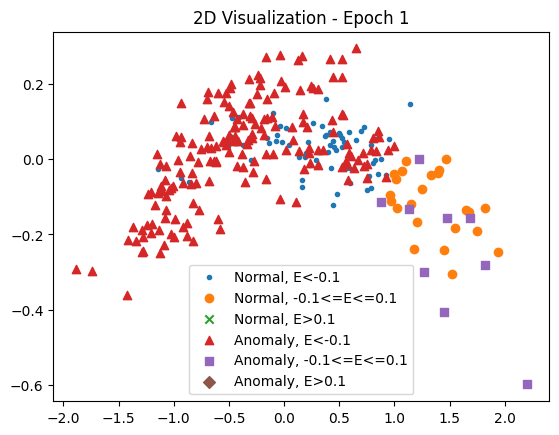

Training Epoch 2:  80%|████████  | 4/5 [00:01<00:00,  2.19it/s]

Epoch 2 - Combined Loss: 0.5679
   => Classification Loss: 0.8442,  Margin Loss: 0.0000,  Triplet: 0.2917
   => Mean Cov Loss: 0.0025  Mean Anom Loss: 0.3410
   => Mean E_norm: -0.2538, E_anom: -0.2410


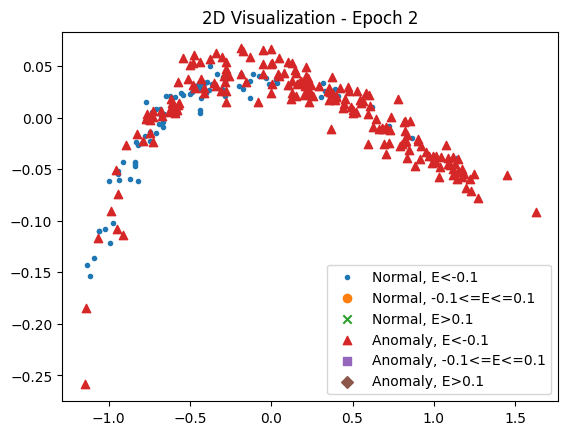

Training Epoch 3:  80%|████████  | 4/5 [00:01<00:00,  2.21it/s]

Epoch 3 - Combined Loss: 0.6311
   => Classification Loss: 0.7804,  Margin Loss: 0.0000,  Triplet: 0.4818
   => Mean Cov Loss: 0.0322  Mean Anom Loss: 0.5527
   => Mean E_norm: -0.4534, E_anom: -0.4527


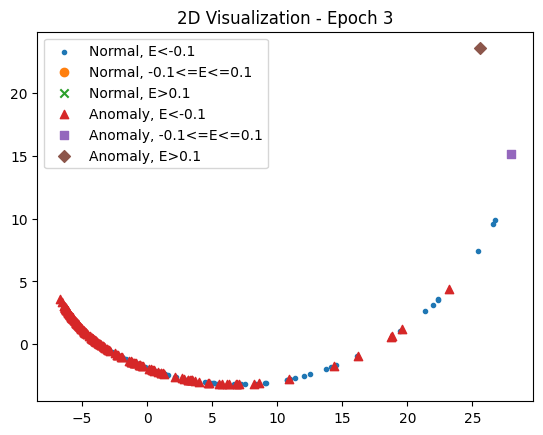

Training Epoch 4:  60%|██████    | 3/5 [00:01<00:00,  2.21it/s]

Epoch 4 - Combined Loss: 0.3997
   => Classification Loss: 0.7687,  Margin Loss: 0.0000,  Triplet: 0.0306
   => Mean Cov Loss: 0.0571  Mean Anom Loss: 0.4230
   => Mean E_norm: -0.2609, E_anom: -0.3054


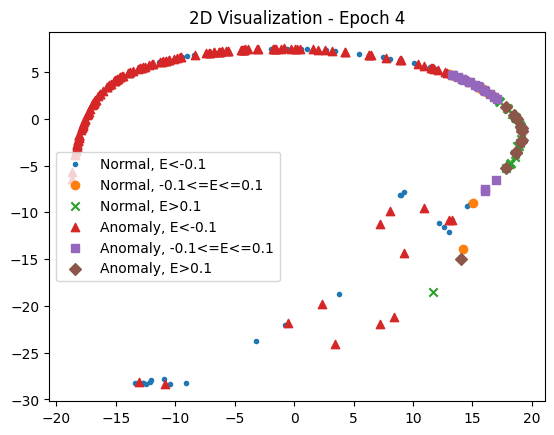

Training Epoch 5: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


Epoch 5 - Combined Loss: 0.3295
   => Classification Loss: 0.6201,  Margin Loss: 0.0000,  Triplet: 0.0389
   => Mean Cov Loss: 0.0340  Mean Anom Loss: 0.6185
   => Mean E_norm: -0.6089, E_anom: -0.5155


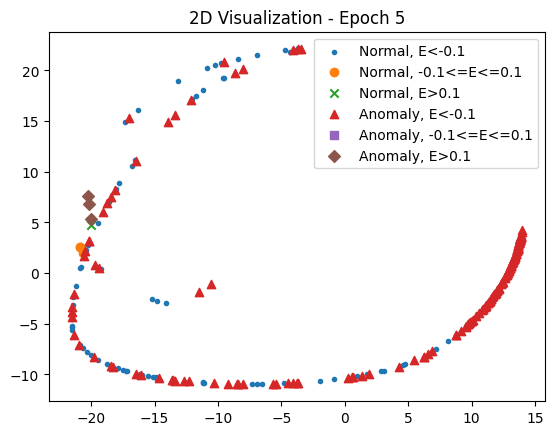

Training Epoch 6: 100%|██████████| 5/5 [00:02<00:00,  2.63it/s]

Epoch 6 - Combined Loss: 0.2741
   => Classification Loss: 0.5333,  Margin Loss: 0.0000,  Triplet: 0.0148
   => Mean Cov Loss: 0.0394  Mean Anom Loss: 0.4492
   => Mean E_norm: -0.4355, E_anom: -0.3444


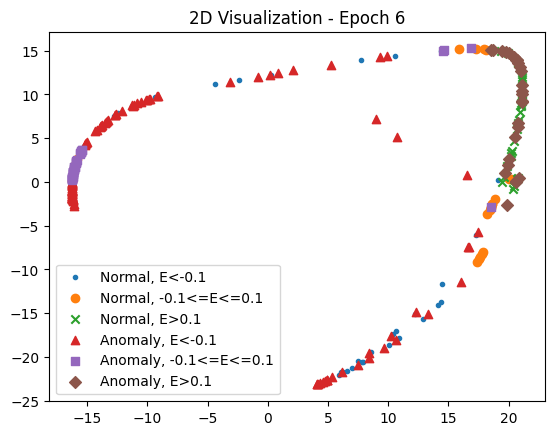

Training Epoch 7: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

Epoch 7 - Combined Loss: 0.2562
   => Classification Loss: 0.5024,  Margin Loss: 0.0000,  Triplet: 0.0099
   => Mean Cov Loss: 0.1306  Mean Anom Loss: 0.2310
   => Mean E_norm: -0.1827, E_anom: -0.0830


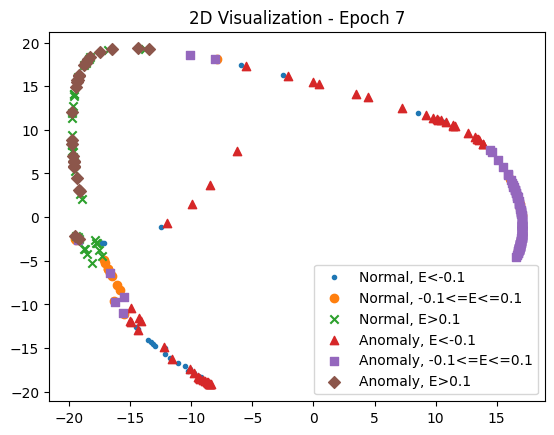

Training Epoch 8: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]

Epoch 8 - Combined Loss: 0.2742
   => Classification Loss: 0.5272,  Margin Loss: 0.0000,  Triplet: 0.0212
   => Mean Cov Loss: 0.1969  Mean Anom Loss: 0.1670
   => Mean E_norm: -0.0511, E_anom: -0.0244


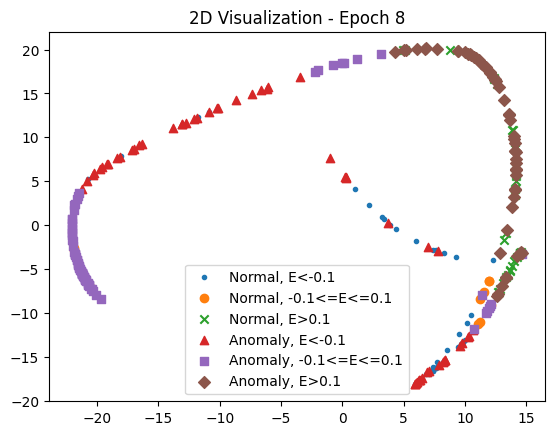

Training Epoch 9:  80%|████████  | 4/5 [00:01<00:00,  2.22it/s]

Epoch 9 - Combined Loss: 0.2620
   => Classification Loss: 0.5064,  Margin Loss: 0.0000,  Triplet: 0.0175
   => Mean Cov Loss: 0.1715  Mean Anom Loss: 0.1813
   => Mean E_norm: -0.0796, E_anom: -0.0187


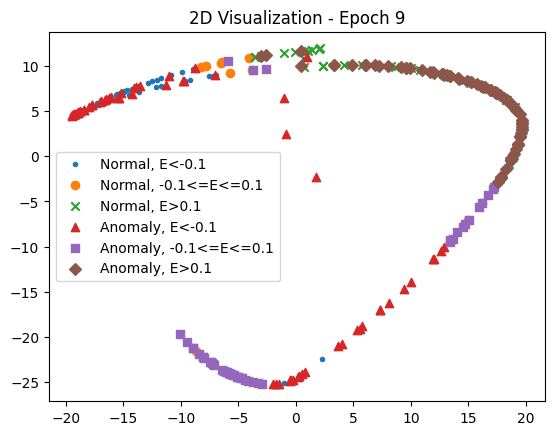

Training Epoch 10: 100%|██████████| 5/5 [00:02<00:00,  2.62it/s]

Epoch 10 - Combined Loss: 0.2931
   => Classification Loss: 0.5472,  Margin Loss: 0.0000,  Triplet: 0.0390
   => Mean Cov Loss: 0.2178  Mean Anom Loss: 0.1559
   => Mean E_norm: 0.0010, E_anom: 0.0271


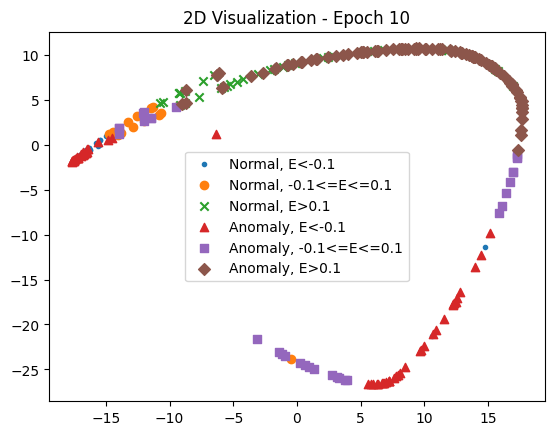

Training Epoch 11: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]

Epoch 11 - Combined Loss: 0.3135
   => Classification Loss: 0.6142,  Margin Loss: 0.0000,  Triplet: 0.0129
   => Mean Cov Loss: 0.2165  Mean Anom Loss: 0.1177
   => Mean E_norm: 0.0906, E_anom: 0.1150


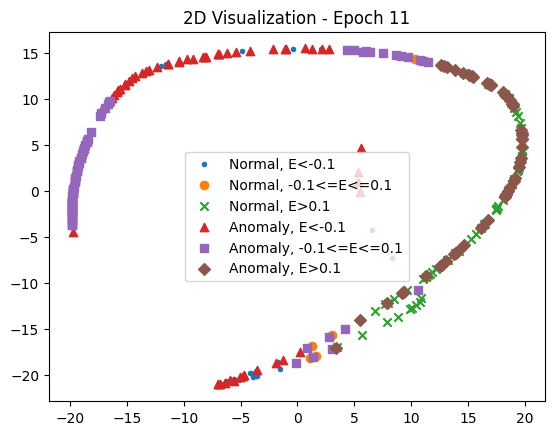

Training Epoch 12: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]

Epoch 12 - Combined Loss: 0.3029
   => Classification Loss: 0.6021,  Margin Loss: 0.0000,  Triplet: 0.0036
   => Mean Cov Loss: 0.2348  Mean Anom Loss: 0.1746
   => Mean E_norm: -0.0236, E_anom: 0.0239


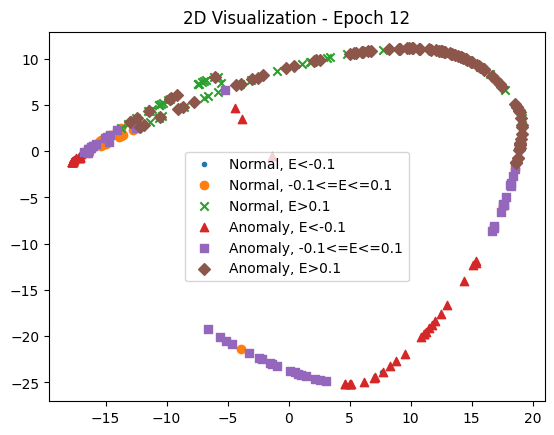

Training Epoch 13: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]

Epoch 13 - Combined Loss: 0.2915
   => Classification Loss: 0.5490,  Margin Loss: 0.0000,  Triplet: 0.0340
   => Mean Cov Loss: 0.2957  Mean Anom Loss: 0.0709
   => Mean E_norm: 0.1893, E_anom: 0.2030


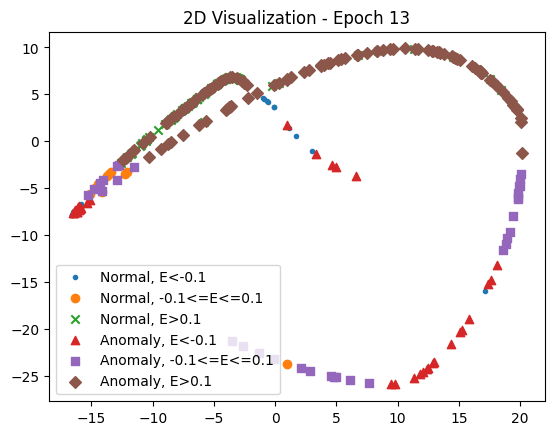

Evaluating: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


Epoch 13 - Test -> Acc=0.8065, Prec=0.8148, Rec=0.9565, F1=0.8800
Confusion Matrix:
 [[ 3  5]
 [ 1 22]]
Epoch 13 - Test Combined Loss: 0.2132


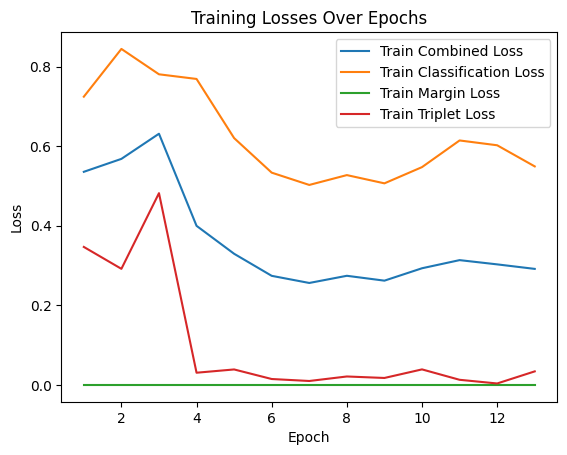

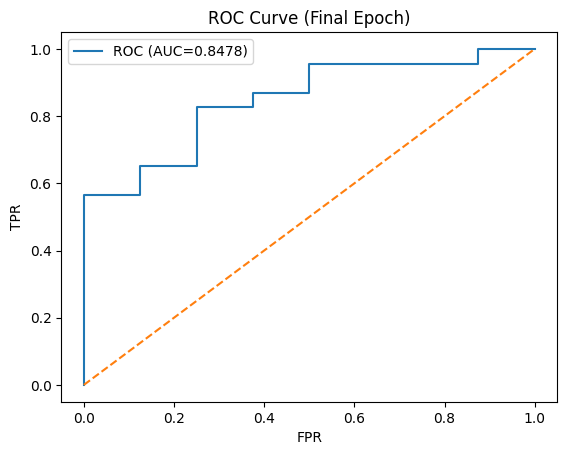


--- A3: random noise -> want no change => 'stability score' is % that kept same label ---
Accuracy:         0.8065
Precision:        0.8148
Recall:           0.9565
F1 Score:         0.8800
Stability Score:  100.0%  (unchanged preds among mutated)

MUTATION ANALYSIS COMPLETED.


In [ ]:
# -*- coding: utf-8 -*-
"""
Energy-Based Anomaly Detection from Tabular Data using ALBERT

Heads:
  - energy head (scalar energy) with hinge margins
  - classifier head (2 classes) with cross-entropy

We use two-phase training:
  Phase 1: classification only
  Phase 2: turn on margin losses
  + a Triplet loss for "shifted normal."

Then we do Mutation Analysis:
  - A1/A2 (large shifts => want the mutated rows to become anomalies)
  - A3 (random noise => want predictions to remain unchanged)
"""

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AlbertModel
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random

# ---------------------------------------------------------------------------
# 1) Reproducibility & Device
# ---------------------------------------------------------------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------------------------
# 2) Load & Preprocess
# ---------------------------------------------------------------------------
file_path = 'vertebral.csv'
df = pd.read_csv(file_path)#.drop(["ID"], axis=1)

def clean_dataframe(df):
    for col in df.select_dtypes(include=['object']):
        df[col] = df[col].replace(r"[:\\[\\],]\'", '', regex=True)
    target_col = "Class"
    majority_value = df[target_col].value_counts().idxmax()
    df[target_col] = df[target_col].apply(lambda x: 1 if x == majority_value else 0)
    df = df.fillna(df.mean())
    return df

df = clean_dataframe(df)
target_col = "Class"

all_cols = [c for c in df.columns if c != target_col]
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(target_col)
categorical_cols = list(set(all_cols) - set(numeric_cols))

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

train_df, test_df = train_test_split(df, test_size=0.1, random_state=SEED)
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

cat_id_maps = {}
cat_dims = {}
for col in categorical_cols:
    df[col] = df[col].astype('category')  # ensure consistent category
    categories = df[col].cat.categories
    cat_id_maps[col] = {cat: i for i, cat in enumerate(categories)}
    cat_dims[col] = len(categories)

def encode_categorical(df, col):
    return df[col].apply(lambda x: cat_id_maps[col].get(x, 0)).values

# ---------------------------------------------------------------------------
# 3) Dataset & Dataloader
# ---------------------------------------------------------------------------
class AnomalyTabularDataset(Dataset):
    def __init__(self, data_df, numeric_cols, categorical_cols, target_col):
        self.df = data_df
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

        self.numeric_data = self.df[self.numeric_cols].astype(np.float32).values

        cat_data_list = []
        for c in self.categorical_cols:
            cat_data_list.append(encode_categorical(self.df, c))
        if len(cat_data_list) == 0:
            self.cat_data = np.zeros((len(self.df), 0), dtype=np.int64)
        else:
            self.cat_data = np.stack(cat_data_list, axis=1).astype(np.int64)

        self.labels = torch.tensor(self.df[target_col].values, dtype=torch.long)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        numeric_row = self.numeric_data[idx]
        cat_row = self.cat_data[idx]
        label = self.labels[idx]
        return {
            "numeric": numeric_row,
            "categorical": cat_row,
            "label": label
        }

def tabular_collate_fn(batch):
    numeric_list = []
    cat_list     = []
    labels_list  = []
    for item in batch:
        numeric_list.append(item["numeric"])
        cat_list.append(item["categorical"])
        labels_list.append(item["label"])
    numeric_tensor = torch.tensor(np.stack(numeric_list), dtype=torch.float32)
    cat_tensor     = torch.tensor(np.stack(cat_list), dtype=torch.long)
    labels_tensor  = torch.stack(labels_list)
    return {
        "numeric": numeric_tensor,
        "categorical": cat_tensor,
        "labels": labels_tensor
    }

train_dataset = AnomalyTabularDataset(train_df, numeric_cols, categorical_cols, target_col)
test_dataset  = AnomalyTabularDataset(test_df,  numeric_cols, categorical_cols, target_col)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=tabular_collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=64, collate_fn=tabular_collate_fn)

# ---------------------------------------------------------------------------
# 4) EnergyBasedTabTransformer
# ---------------------------------------------------------------------------
class EnergyBasedTabTransformer(nn.Module):
    def __init__(self, albert_model, numeric_dim, categorical_cols, cat_dims):
        super().__init__()
        self.albert_encoder = albert_model.encoder
        self.config = albert_model.config
        self.embedding_size = self.config.embedding_size

        self.numeric_linear = nn.Linear(numeric_dim, self.embedding_size)

        self.categorical_cols = categorical_cols
        self.cat_embeddings = nn.ModuleList()
        for col in categorical_cols:
            vocab_size = cat_dims[col]
            emb = nn.Embedding(vocab_size, self.embedding_size)
            self.cat_embeddings.append(emb)

        self.cls_token = nn.Parameter(torch.zeros(1,1,self.embedding_size))
        self.energy_layer = nn.Linear(self.config.hidden_size, 1)
        self.classifier   = nn.Linear(self.config.hidden_size, 2)

    def forward(self, numeric, categorical, return_cls_emb=False):
        bsz = numeric.size(0)
        numeric_embed = self.numeric_linear(numeric).unsqueeze(1)

        if len(self.categorical_cols) > 0:
            cat_embeds_list = []
            for i, emb_layer in enumerate(self.cat_embeddings):
                cat_ids = categorical[:, i]
                cat_emb = emb_layer(cat_ids)
                cat_embeds_list.append(cat_emb.unsqueeze(1))
            cat_embeds = torch.cat(cat_embeds_list, dim=1)
        else:
            cat_embeds = torch.zeros(bsz, 0, self.embedding_size, device=numeric.device)

        cls_tok = self.cls_token.expand(bsz, -1, -1)
        seq_embeds = torch.cat([cls_tok, numeric_embed, cat_embeds], dim=1)
        seq_len = seq_embeds.size(1)

        attention_mask = torch.ones(bsz, seq_len, device=seq_embeds.device)
        extended_mask  = self._convert_mask(attention_mask, seq_embeds.dtype)

        outputs = self.albert_encoder(
            hidden_states=seq_embeds,
            attention_mask=extended_mask,
            head_mask=[None]*self.config.num_hidden_layers,
            output_hidden_states=True
        )
        last_hidden_state = outputs.hidden_states[-1]
        cls_embedding = last_hidden_state[:,0,:]

        energy_score = self.energy_layer(cls_embedding).squeeze(-1)
        logits       = self.classifier(cls_embedding)

        if return_cls_emb:
            return energy_score, logits, cls_embedding
        else:
            return energy_score, logits

    def _convert_mask(self, attention_mask, dtype):
        extended_mask = attention_mask.unsqueeze(1).unsqueeze(2).to(dtype=dtype)
        extended_mask = (1.0 - extended_mask)*(-10000.0)
        return extended_mask

# ---------------------------------------------------------------------------
# 5) Combined Loss: CE + margin
# ---------------------------------------------------------------------------
def combined_loss(energy_scores, logits, labels,
                  margin_normal, margin_anomaly,
                  lambda_cls=1.0,
                  lambda_margin_normal=1.0,
                  lambda_margin_anomaly=1.0,
                  weight=None,
                  return_components=False):
    """
    L_total = λ_cls * L_cls + (λ_margin_normal * L_cov + λ_margin_anomaly * L_anom)
    If return_components=True, also return (L_cls.item(), L_margin.item()) for logging.
    """
    weight=None
    if weight is not None:
        criterion = nn.CrossEntropyLoss(weight=weight)
    else:
        criterion = nn.CrossEntropyLoss()

    L_cls = criterion(logits, labels)

    normal_mask  = (labels == 0)
    anomaly_mask = (labels == 1)

    L_cov = torch.mean(F.relu(energy_scores[normal_mask] - margin_normal)) if normal_mask.sum()>0 else 0.0
    L_anom= torch.mean(F.relu(margin_anomaly - energy_scores[anomaly_mask])) if anomaly_mask.sum()>0 else 0.0
    L_margin = lambda_margin_normal * L_cov + lambda_margin_anomaly * L_anom

    total_loss = lambda_cls * L_cls + L_margin

    if return_components:
        return total_loss, L_cls.item(), L_margin.item()
    else:
        return total_loss

# ---------------------------------------------------------------------------
# 6) Evaluate Model
# ---------------------------------------------------------------------------
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_preds  = []
    all_logits = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            numeric = batch["numeric"].to(device)
            categorical = batch["categorical"].to(device)
            labels = batch["labels"].to(device)

            _, logits = model(numeric, categorical)
            preds = torch.argmax(logits, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_logits.append(logits.cpu().numpy())

    all_logits = np.concatenate(all_logits, axis=0)
    all_labels = np.array(all_labels)
    all_preds  = np.array(all_preds)

    accuracy  = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall    = recall_score(all_labels, all_preds, zero_division=0)
    f1        = f1_score(all_labels, all_preds, zero_division=0)
    return accuracy, precision, recall, f1, all_labels, all_preds, all_logits

# ---------------------------------------------------------------------------
# 7) Visualization in 2D
# ---------------------------------------------------------------------------
def visualize_in_2D(model, data_loader, epoch=0,
                    margin_normal=-0.1, margin_anomaly=0.1):
    model.eval()
    all_embeddings = []
    all_energies   = []
    all_labels     = []

    with torch.no_grad():
        for batch in data_loader:
            numeric = batch["numeric"].to(device)
            categorical = batch["categorical"].to(device)
            labels = batch["labels"].to(device)

            energy_scores, _, cls_emb = model(numeric, categorical, return_cls_emb=True)

            all_embeddings.append(cls_emb.cpu().numpy())
            all_energies.append(energy_scores.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    embeddings_array = np.concatenate(all_embeddings, axis=0)
    energies_array   = np.concatenate(all_energies, axis=0)
    labels_array     = np.concatenate(all_labels, axis=0)

    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    coords_2D = pca.fit_transform(embeddings_array)

    normal_mask  = (labels_array==0)
    anomaly_mask = (labels_array==1)

    zoneA_mask = (energies_array < margin_normal)
    zoneB_mask = (energies_array>=margin_normal)&(energies_array<=margin_anomaly)
    zoneC_mask = (energies_array>margin_anomaly)

    normalA = normal_mask & zoneA_mask
    normalB = normal_mask & zoneB_mask
    normalC = normal_mask & zoneC_mask
    anomA   = anomaly_mask & zoneA_mask
    anomB   = anomaly_mask & zoneB_mask
    anomC   = anomaly_mask & zoneC_mask

    plt.figure()
    plt.title(f"2D Visualization - Epoch {epoch}")

    # Normal
    plt.scatter(coords_2D[normalA,0], coords_2D[normalA,1], marker='.', label=f"Normal, E<{margin_normal}")
    plt.scatter(coords_2D[normalB,0], coords_2D[normalB,1], marker='o', label=f"Normal, {margin_normal}<=E<={margin_anomaly}")
    plt.scatter(coords_2D[normalC,0], coords_2D[normalC,1], marker='x', label=f"Normal, E>{margin_anomaly}")

    # Anomaly
    plt.scatter(coords_2D[anomA,0], coords_2D[anomA,1], marker='^', label=f"Anomaly, E<{margin_normal}")
    plt.scatter(coords_2D[anomB,0], coords_2D[anomB,1], marker='s', label=f"Anomaly, {margin_normal}<=E<={margin_anomaly}")
    plt.scatter(coords_2D[anomC,0], coords_2D[anomC,1], marker='D', label=f"Anomaly, E>{margin_anomaly}")

    plt.legend()
    plt.show(block=False)
    plt.pause(1.0)

# ---------------------------------------------------------------------------
# 8) Train in Two Phases w/Triplet Loss, capturing separate loss components
#    plus adding test-set combined loss each epoch
# ---------------------------------------------------------------------------
albert_model = AlbertModel.from_pretrained("albert-base-v2")
model = EnergyBasedTabTransformer(
    albert_model,
    numeric_dim=len(numeric_cols),
    categorical_cols=categorical_cols,
    cat_dims=cat_dims
).to(device)

optimizer = AdamW(model.parameters(), lr=5e-4)

num_epochs = 13
margin_normal  = -0.1
margin_anomaly =  0.1
phase1_end     = 13

lambda_cls_list     = []
lambda_cov_list     = []
lambda_anomaly_list = []

for epoch in range(num_epochs):
    if epoch < phase1_end:
        lambda_cls     = 0.5
        lambda_cov     = 0.0
        lambda_anomaly = 0.0
    else:
        lambda_cls     = 0.1
        lambda_cov     = 0.1
        lambda_anomaly = 0.3
    lambda_cls_list.append(lambda_cls)
    lambda_cov_list.append(lambda_cov)
    lambda_anomaly_list.append(lambda_anomaly)

triplet_loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)
lambda_triplet  = 0.5
noise_std       = 0.01

# Lists for plotting:
epoch_total_losses       = []  # combined train
epoch_classification_losses = []
epoch_margin_losses      = []
epoch_triplet_losses     = []
epoch_test_losses        = []  # new list for test combined loss

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    classification_loss_sum = 0.0
    margin_loss_sum   = 0.0
    triplet_loss_sum  = 0.0

    cov_vals, anom_vals = [], []
    normal_e_vals, anomaly_e_vals = [], []

    curr_lambda_cls     = lambda_cls_list[epoch]
    curr_lambda_cov     = lambda_cov_list[epoch]
    curr_lambda_anomaly = lambda_anomaly_list[epoch]

    phase_label = "1" if epoch < phase1_end else "2"
    print(f"\nEpoch {epoch+1}/{num_epochs} [Phase {phase_label}] "
          f"λ_cls={curr_lambda_cls}, λ_cov={curr_lambda_cov}, λ_anomaly={curr_lambda_anomaly}, λ_triplet={lambda_triplet}")

    batch_count = 0
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        batch_count += 1

        numeric = batch["numeric"].to(device)
        categorical = batch["categorical"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        energy_scores, logits, embeddings = model(numeric, categorical, return_cls_emb=True)

        # Weighted CE
        train_labels = train_dataset.labels.numpy()
        class_counts = np.bincount(train_labels)
        total_data   = len(train_labels)
        num_classes  = len(class_counts)
        weights = total_data / (num_classes * class_counts)
        weights = torch.tensor(weights, dtype=torch.float32).to(device)

        # We request separate L_cls, L_margin from combined_loss
        combined_val, L_cls_val, L_margin_val = combined_loss(
            energy_scores, logits, labels,
            margin_normal=margin_normal,
            margin_anomaly=margin_anomaly,
            lambda_cls=curr_lambda_cls,
            lambda_margin_normal=curr_lambda_cov,
            lambda_margin_anomaly=curr_lambda_anomaly,
            weight=weights,
            return_components=True
        )

        # triplet
        normal_indices = (labels == 0).nonzero(as_tuple=False).squeeze()
        anomaly_indices= (labels == 1).nonzero(as_tuple=False).squeeze()
        trip_loss_val  = torch.tensor(0.0, device=device)

        if normal_indices.numel()>0 and anomaly_indices.numel()>0:
            anchor_embeddings = embeddings[normal_indices]
            positive_embeddings = anchor_embeddings + torch.randn_like(anchor_embeddings)*noise_std
            if anomaly_indices.dim()==0:
                anomaly_indices = anomaly_indices.unsqueeze(0)
            negative_embeddings = embeddings[anomaly_indices]
            n_anchors = anchor_embeddings.size(0)
            rand_idx  = torch.randint(0, negative_embeddings.size(0), (n_anchors,), device=device)
            negatives_sampled = negative_embeddings[rand_idx]
            trip_loss_val = triplet_loss_fn(anchor_embeddings, positive_embeddings, negatives_sampled)

        total_batch_loss = combined_val + lambda_triplet * trip_loss_val
        total_batch_loss.backward()
        optimizer.step()

        total_loss += total_batch_loss.item()
        classification_loss_sum += L_cls_val
        margin_loss_sum         += L_margin_val
        triplet_loss_sum        += trip_loss_val.item()

        # track margin stats for debugging
        normal_mask = (labels==0)
        anomaly_mask= (labels==1)
        if normal_mask.sum()>0:
            L_cov_batch = F.relu(energy_scores[normal_mask] - margin_normal).mean().item()
            normal_e_vals.append(energy_scores[normal_mask].mean().item())
        else:
            L_cov_batch = 0.0
            normal_e_vals.append(0.0)

        if anomaly_mask.sum()>0:
            L_anom_batch = F.relu(margin_anomaly - energy_scores[anomaly_mask]).mean().item()
            anomaly_e_vals.append(energy_scores[anomaly_mask].mean().item())
        else:
            L_anom_batch = 0.0
            anomaly_e_vals.append(0.0)

        cov_vals.append(L_cov_batch)
        anom_vals.append(L_anom_batch)

    # Averages over training batches
    avg_combined_loss = total_loss / batch_count
    avg_cls_loss      = classification_loss_sum / batch_count
    avg_margin_loss   = margin_loss_sum / batch_count
    avg_trip_loss     = triplet_loss_sum / batch_count

    avg_cov   = np.mean(cov_vals)
    avg_anom  = np.mean(anom_vals)
    avg_nrg_n = np.mean(normal_e_vals)
    avg_nrg_a = np.mean(anomaly_e_vals)

    print(f"Epoch {epoch+1} - Combined Loss: {avg_combined_loss:.4f}")
    print(f"   => Classification Loss: {avg_cls_loss:.4f},  Margin Loss: {avg_margin_loss:.4f},  Triplet: {avg_trip_loss:.4f}")
    print(f"   => Mean Cov Loss: {avg_cov:.4f}  Mean Anom Loss: {avg_anom:.4f}")
    print(f"   => Mean E_norm: {avg_nrg_n:.4f}, E_anom: {avg_nrg_a:.4f}")

    # Visualization each epoch
    visualize_in_2D(model, train_loader, epoch=epoch+1,
                    margin_normal=margin_normal, margin_anomaly=margin_anomaly)

    # Evaluate on test for metrics:
    accuracy, precision, recall, f1, all_labels, all_preds, all_logits = evaluate_model(model, test_loader)
    print(f"Epoch {epoch+1} - Test -> Acc={accuracy:.4f}, Prec={precision:.4f}, Rec={recall:.4f}, F1={f1:.4f}")
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)

    # Also compute "combined loss" on test set (no triplet for test) to track
    model.eval()
    test_loss_sum = 0.0
    test_batches  = 0
    with torch.no_grad():
        for b_test in test_loader:
            test_batches += 1
            numeric_t = b_test["numeric"].to(device)
            categorical_t = b_test["categorical"].to(device)
            labels_t = b_test["labels"].to(device)

            energy_t, logits_t = model(numeric_t, categorical_t)
            # same weighting used for train or no weighting? We'll keep it consistent
            test_loss_val = combined_loss(
                energy_t, logits_t, labels_t,
                margin_normal=margin_normal,
                margin_anomaly=margin_anomaly,
                lambda_cls=curr_lambda_cls,
                lambda_margin_normal=curr_lambda_cov,
                lambda_margin_anomaly=curr_lambda_anomaly,
                weight=weights,
                return_components=False
            )
            test_loss_sum += test_loss_val.item()

    test_loss_avg = test_loss_sum / test_batches
    print(f"Epoch {epoch+1} - Test Combined Loss: {test_loss_avg:.4f}")

    # Store for plotting after
    epoch_total_losses.append(avg_combined_loss)
    epoch_classification_losses.append(avg_cls_loss)
    epoch_margin_losses.append(avg_margin_loss)
    epoch_triplet_losses.append(avg_trip_loss)
    epoch_test_losses.append(test_loss_avg)

# After training, let's plot all separate losses (train) + test combined
plt.figure()
plt.plot(range(1, num_epochs+1), epoch_total_losses, label='Train Combined Loss')
plt.plot(range(1, num_epochs+1), epoch_classification_losses, label='Train Classification Loss')
plt.plot(range(1, num_epochs+1), epoch_margin_losses, label='Train Margin Loss')
plt.plot(range(1, num_epochs+1), epoch_triplet_losses, label='Train Triplet Loss')
#plt.plot(range(1, num_epochs+1), epoch_test_losses, label='Test Combined Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses Over Epochs")
plt.legend()
plt.show()

# final ROC
pos_probs = torch.softmax(torch.tensor(all_logits), dim=1).numpy()[:,1]
fpr, tpr, thresholds = roc_curve(all_labels, pos_probs)
auc_value = roc_auc_score(all_labels, pos_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={auc_value:.4f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve (Final Epoch)")
plt.legend()
plt.show()

(accuracy, precision, recall, f1)


# ---------------------------------------------------------------------------
# 9) Systematic Mutants: A1/A2 => want new label=anomaly, A3 => want stability
# ---------------------------------------------------------------------------

def anomaly_injection_a1_a2(
    X,
    mutation_fraction=0.05,
    min_mutations=2,
    num_features=1,
    intensity="moderate"
):
    intensity_levels = {
        "weak":[0.25,0.5,0.75],
        "moderate":[1,1.5,2],
        "strong":[8,9,10]
    }
    if intensity not in intensity_levels:
        raise ValueError("Invalid intensity for A1/A2")

    all_num = X.select_dtypes(include=['number']).columns
    numeric_columns = [c for c in all_num if c != "Class"]
    if len(numeric_columns)<num_features:
        raise ValueError("Not enough numeric columns for A1/A2")

    selected_features = random.sample(list(numeric_columns), num_features)
    X = X.copy()
    mutated_indices_set= set()
    mutated_feature_names=[]

    for feature in selected_features:
        std_dev = X[feature].std()
        mutation_factors = [m*std_dev for m in intensity_levels[intensity]]
        mutation_factor  = np.random.choice(mutation_factors)

        num_mutations = max(min_mutations,int(mutation_fraction*len(X)))
        num_mutations = min(num_mutations, len(X))

        mutated_rows = np.random.choice(X.index, size=num_mutations, replace=False)
        mutated_indices_set.update(mutated_rows)

        before_vals = X.loc[mutated_rows, feature].copy()
        small_value = std_dev*0.025
        X.loc[mutated_rows, feature] = np.where(
            X.loc[mutated_rows, feature]==0,
            small_value/10,
            X.loc[mutated_rows, feature]
        )
        X.loc[mutated_rows, feature] += mutation_factor*np.sign(X.loc[mutated_rows, feature])
        after_vals = X.loc[mutated_rows, feature].copy()

        #print(f"A1/A2 injected in {feature} factor={mutation_factor:.3f} (intensity={intensity})")
        #print(pd.DataFrame({"Before":before_vals,"After":after_vals}),"\n")

        mutated_feature_names.append(feature)

    '''if len(selected_features)>1:
        print(f"A2 mutated columns (together): {mutated_feature_names}\n")
    else:
        print(f"A1 mutated column: {mutated_feature_names}\n")'''

    mutated_indices = sorted(list(mutated_indices_set))
    return X, mutated_indices, mutated_feature_names

def anomaly_injection_a3(
    X,
    mutation_fraction=0.05,
    min_mutations=2,
    num_features=1,
    intensity="moderate"
):
    intensity_levels = {
        "weak":0.01,
        "moderate":0.05,
        "strong":1.0
    }
    if intensity not in intensity_levels:
        raise ValueError("Invalid intensity for A3")

    noise_level = intensity_levels[intensity]
    all_num = X.select_dtypes(include=['number']).columns
    numeric_columns = [c for c in all_num if c != "Class"]
    if len(numeric_columns)<num_features:
        raise ValueError("Not enough numeric columns for A3")

    selected_features= random.sample(list(numeric_columns), num_features)
    X = X.copy()
    mutated_indices_set=set()

    for feature in selected_features:
        std_dev = X[feature].std()
        num_mutations= max(min_mutations,int(mutation_fraction*len(X)))
        num_mutations= min(num_mutations,len(X))

        mutation_rows = np.random.choice(X.index,size=num_mutations,replace=False)
        mutated_indices_set.update(mutation_rows)

        before_vals = X.loc[mutation_rows,feature].values
        noise = np.random.normal(loc=0, scale=noise_level*std_dev, size=num_mutations)
        X.loc[mutation_rows,feature] = np.clip(
            X.loc[mutation_rows,feature]+noise,
            a_min=0,
            a_max=None
        )
        after_vals = X.loc[mutation_rows,feature].values

        #print(f"A3 injected in {feature}, intensity={intensity}, noise_level={noise_level}, std={std_dev:.3f}")
        #print("Before:\n", before_vals)
        #print("After:\n", after_vals,"\n")

    mutated_indices = sorted(list(mutated_indices_set))
    return X, mutated_indices, selected_features

def get_predictions_for_df(model, df_data):
    df_temp = df_data.reset_index(drop=True).copy()
    for col in categorical_cols:
        df_temp[col] = df_temp[col].apply(lambda x: cat_id_maps[col].get(x, 0))

    from torch.utils.data import DataLoader
    ds_temp = AnomalyTabularDataset(df_temp, numeric_cols, categorical_cols, target_col)
    ld_temp = DataLoader(ds_temp, batch_size=64, collate_fn=tabular_collate_fn)

    all_preds=[]
    model.eval()
    with torch.no_grad():
        for b_test in ld_temp:
            numeric_t = b_test["numeric"].to(device)
            categorical_t = b_test["categorical"].to(device)
            _, logits_t = model(numeric_t, categorical_t)
            preds_t = torch.argmax(logits_t, dim=1)
            all_preds.extend(preds_t.cpu().tolist())
    return np.array(all_preds)

def evaluate_mutation_a1_a2(df_mutated, mutated_indices, model):
    from torch.utils.data import DataLoader
    ds_mut = AnomalyTabularDataset(df_mutated, numeric_cols, categorical_cols, target_col)
    ld_mut = DataLoader(ds_mut, batch_size=64, collate_fn=tabular_collate_fn)

    acc, prec, rec, f1, _, mut_preds, _ = evaluate_model(model, ld_mut)
    mut_preds_arr = get_predictions_for_df(model, df_mutated)

    predicted_anomaly = 0
    for row_idx in mutated_indices:
        if mut_preds_arr[row_idx]==1:
            predicted_anomaly +=1

    total_mut = len(mutated_indices)
    if total_mut>0:
        mutation_score = 100.0 * predicted_anomaly / total_mut
    else:
        mutation_score=0.0

    return acc, prec, rec, f1, mutation_score

def evaluate_mutation_a3_stability(df_mutated, mutated_indices, orig_preds, model):
    from torch.utils.data import DataLoader
    ds_mut = AnomalyTabularDataset(df_mutated, numeric_cols, categorical_cols, target_col)
    ld_mut = DataLoader(ds_mut, batch_size=64, collate_fn=tabular_collate_fn)

    acc, prec, rec, f1, _, mut_preds, _ = evaluate_model(model, ld_mut)
    mut_preds_arr = get_predictions_for_df(model, df_mutated)

    changed = 0
    for row_idx in mutated_indices:
        if orig_preds[row_idx]!=mut_preds_arr[row_idx]:
            changed+=1
    total = len(mutated_indices)
    if total>0:
        stability_score=100.0*(total-changed)/total
    else:
        stability_score=100.0

    return acc, prec, rec, f1, stability_score

print("\n============================")
print("MUTATION ANALYSIS (SYSTEMATIC MUTANTS)")
print("============================")

orig_preds_for_test = get_predictions_for_df(model, test_df)

df_a1, mut_idxs_a1, feats_a1 = anomaly_injection_a1_a2(
    X=test_df.copy(),
    mutation_fraction=0.1,
    min_mutations=2,
    num_features=1,
    intensity="strong"
)
a1_acc, a1_prec, a1_rec, a1_f1, a1_score = evaluate_mutation_a1_a2(df_a1, mut_idxs_a1, model)
print(f"\n--- A1: single feature shift -> want anomaly => 'mutation score' is % predicted=1 among mutated ---")
print(f"Accuracy:        {a1_acc:.4f}")
print(f"Precision:       {a1_prec:.4f}")
print(f"Recall:          {a1_rec:.4f}")
print(f"F1 Score:        {a1_f1:.4f}")
print(f"Mutation Score:  {a1_score:.1f}%  (# predicted anomaly among mutated)")

df_a2, mut_idxs_a2, feats_a2 = anomaly_injection_a1_a2(
    X=test_df.copy(),
    mutation_fraction=0.1,
    min_mutations=2,
    num_features=3,
    intensity="strong"
)
a2_acc, a2_prec, a2_rec, a2_f1, a2_score = evaluate_mutation_a1_a2(df_a2, mut_idxs_a2, model)
print(f"\n--- A2: multiple feature shift -> want anomaly => 'mutation score' is % predicted=1 among mutated ---")
print(f"Accuracy:        {a2_acc:.4f}")
print(f"Precision:       {a2_prec:.4f}")
print(f"Recall:          {a2_rec:.4f}")
print(f"F1 Score:        {a2_f1:.4f}")
print(f"Mutation Score:  {a2_score:.1f}%  (# predicted anomaly among mutated)")

df_a3, mut_idxs_a3, feats_a3 = anomaly_injection_a3(
    X=test_df.copy(),
    mutation_fraction=0.1,
    min_mutations=2,
    num_features=2,
    intensity="weak"
)
a3_acc, a3_prec, a3_rec, a3_f1, a3_stability = evaluate_mutation_a3_stability(
    df_a3, mut_idxs_a3, orig_preds_for_test, model
)
print(f"\n--- A3: random noise -> want no change => 'stability score' is % that kept same label ---")
print(f"Accuracy:         {a3_acc:.4f}")
print(f"Precision:        {a3_prec:.4f}")
print(f"Recall:           {a3_rec:.4f}")
print(f"F1 Score:         {a3_f1:.4f}")
print(f"Stability Score:  {a3_stability:.1f}%  (unchanged preds among mutated)")

print("\nMUTATION ANALYSIS COMPLETED.")
